# Lab 4

Mikhail working notes

### Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras

keras.utils.set_random_seed(812)

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

(train_data, train_labels), (test_data, test_labels) = keras.datasets.reuters.load_data(num_words = 10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Shape from 8982, to  to 8982,46
one_hot_train_labels = keras.utils.to_categorical(train_labels)
one_hot_test_lables = keras.utils.to_categorical(test_labels)

partial_x_train=x_train[1000:]
partial_y_train=one_hot_train_labels[1000:]
x_val=x_train[:1000]
y_val=one_hot_train_labels[:1000]

In [64]:
model = keras.models.Sequential()
model.add(keras.Input((10000,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(46, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Data

A data point is an article, encoded as an erray, where each element is a word index. Words are indexed by frequency, so 1 is the most common word.

A label is a topic.

In [ ]:
mapping = keras.datasets.reuters.get_word_index(path="reuters_word_index.json")
print(f"'The' has index: {mapping['the']}")

reverse_mapping = {value + 3: key for key, value in mapping.items()}
print(f"The fourth most common word is: {reverse_mapping[5]}")

article = [reverse_mapping.get(word_index, '?') for word_index in train_data[0]]

print(" ".join(article))


'The' has index: 1
The fourth most common word is: of
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Baseline

This is classification, so our first guess is $\frac{1}{classes}$.

In [78]:
# Show number of classes
print(f"Classes: {y_val.shape[1]}")

correct = (np.random.randint(0, 46, size=len(test_labels)) == test_labels).sum()
print(f"Baseline random: {correct / len(test_labels)}")



Classes: 46
Baseline random: 0.018699910952804988


In [ ]:
# Look at data set for balance
plt.bar(*np.unique(train_labels, return_counts=True))
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Since the data set is imbalanced, we guess the the most common class instead.

In [62]:
# Get the most common
labels, counts = np.unique(train_labels, return_counts = True)
most_frequent = labels[counts.argmax()]
print(f"most frequent label: {most_frequent}")

correct = (np.full(len(test_labels), 3) == test_labels).sum()
print(f"Baseline most common: {correct / len(test_labels)}")


most frequent label: 3
Baseline most common: 0.3619768477292965


**Sanity check**

In [68]:
loss, accuracy = model.evaluate(partial_x_train, partial_y_train, verbose=0)
print(f"baseline loss: {loss}, baseline accuracy: {accuracy}")

baseline loss: 3.843754291534424, baseline accuracy: 0.005888248328119516


This is not what I would expect. I would expect the untrained model to be about as good as random (~2.0% accuracy), but this has 0.05% accuracy.

Why is this?

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


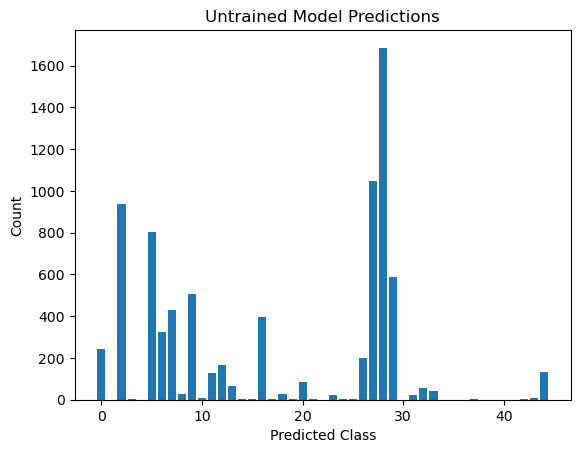

In [80]:
preds = model.predict(partial_x_train).argmax(axis=1)
labels, counts = np.unique(preds, return_counts=True)

plt.bar(labels, counts)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Untrained Model Predictions')
plt.show()

In [93]:
def softmax(x):
    e = np.exp(x)
    return e / e.sum()

logits = np.array([1.01, 1.02, 0.99])
softmaxed = softmax(logits)

print(softmaxed)

[0.33442033 0.33778131 0.32779836]


It turns out it is because an untrained model does not produce an even distribution.

An untrained model has random weights/biases (small numbers), so it is cutting up space in lots of random ways.

If we give it an input set, it cuts it up, somewhat randomly, *but with small uneveness.*

But then the output logits are softmaxed, which makes the small uneveness in the cuts super amplified, so we get very unbalanced distribution.

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


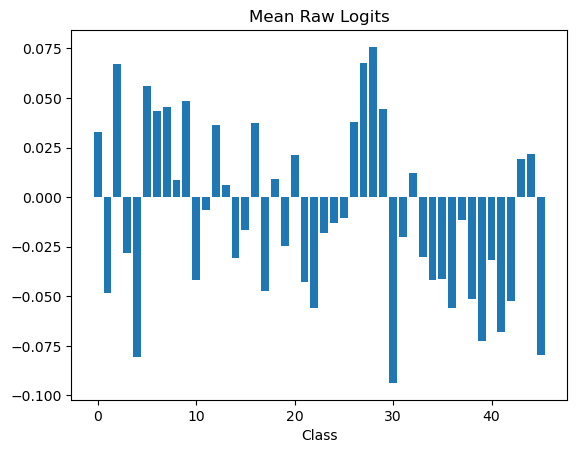

In [ ]:
def show_logits():
    model_linear = keras.models.Sequential()
    model_linear.add(keras.Input((10000,)))
    model_linear.add(keras.layers.Dense(64, activation='relu'))
    model_linear.add(keras.layers.Dense(64, activation='relu'))
    model_linear.add(keras.layers.Dense(46, activation='linear'))

    model_linear.set_weights(model.get_weights())

    logits = model_linear.predict(partial_x_train)
    mean_logits = logits.mean(axis=0)

    plt.bar(range(46), mean_logits)
    plt.title('Mean Raw Logits (before softmax)')
    plt.xlabel('Class')
    plt.show()

show_logits()


So, we see that the actual logits have minimal differences, the peak around 30 is only 0.05, but is then amplified by softmax.